In [1]:
from ctypes import *
import math
import random
import os
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def sample(probs):
    s = sum(probs)
    probs = [a/s for a in probs]
    r = random.uniform(0, 1)
    for i in range(len(probs)):
        r = r - probs[i]
        if r <= 0:
            return i
    return len(probs)-1

def c_array(ctype, values):
    arr = (ctype*len(values))()
    arr[:] = values
    return arr

class BOX(Structure):
    _fields_ = [("x", c_float),
                ("y", c_float),
                ("w", c_float),
                ("h", c_float)]

class DETECTION(Structure):
    _fields_ = [("bbox", BOX),
                ("classes", c_int),
                ("prob", POINTER(c_float)),
                ("mask", POINTER(c_float)),
                ("objectness", c_float),
                ("sort_class", c_int)]


class IMAGE(Structure):
    _fields_ = [("w", c_int),
                ("h", c_int),
                ("c", c_int),
                ("data", POINTER(c_float))]

class METADATA(Structure):
    _fields_ = [("classes", c_int),
                ("names", POINTER(c_char_p))]

In [2]:
lib = CDLL("../libdarknet.so", RTLD_GLOBAL)
lib.network_width.argtypes = [c_void_p]
lib.network_width.restype = c_int
lib.network_height.argtypes = [c_void_p]
lib.network_height.restype = c_int

In [3]:
predict = lib.network_predict
predict.argtypes = [c_void_p, POINTER(c_float)]
predict.restype = POINTER(c_float)

set_gpu = lib.cuda_set_device
set_gpu.argtypes = [c_int]

make_image = lib.make_image
make_image.argtypes = [c_int, c_int, c_int]
make_image.restype = IMAGE

get_network_boxes = lib.get_network_boxes
get_network_boxes.argtypes = [c_void_p, c_int, c_int, c_float, c_float, POINTER(c_int), c_int, POINTER(c_int)]
get_network_boxes.restype = POINTER(DETECTION)

make_network_boxes = lib.make_network_boxes
make_network_boxes.argtypes = [c_void_p]
make_network_boxes.restype = POINTER(DETECTION)

free_detections = lib.free_detections
free_detections.argtypes = [POINTER(DETECTION), c_int]

free_ptrs = lib.free_ptrs
free_ptrs.argtypes = [POINTER(c_void_p), c_int]

In [4]:
network_predict = lib.network_predict
network_predict.argtypes = [c_void_p, POINTER(c_float)]

reset_rnn = lib.reset_rnn
reset_rnn.argtypes = [c_void_p]

load_net = lib.load_network
load_net.argtypes = [c_char_p, c_char_p, c_int]
load_net.restype = c_void_p

do_nms_obj = lib.do_nms_obj
do_nms_obj.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]

do_nms_sort = lib.do_nms_sort
do_nms_sort.argtypes = [POINTER(DETECTION), c_int, c_int, c_float]

free_image = lib.free_image
free_image.argtypes = [IMAGE]

letterbox_image = lib.letterbox_image
letterbox_image.argtypes = [IMAGE, c_int, c_int]
letterbox_image.restype = IMAGE

load_meta = lib.get_metadata
lib.get_metadata.argtypes = [c_char_p]
lib.get_metadata.restype = METADATA

load_image = lib.load_image_color
load_image.argtypes = [c_char_p, c_int, c_int]
load_image.restype = IMAGE

rgbgr_image = lib.rgbgr_image
rgbgr_image.argtypes = [IMAGE]

predict_image = lib.network_predict_image
predict_image.argtypes = [c_void_p, IMAGE]
predict_image.restype = POINTER(c_float)

In [5]:
def classify(net, meta, im):
    out = predict_image(net, im)
    res = []
    for i in range(meta.classes):
        res.append((meta.names[i], out[i]))
    res = sorted(res, key=lambda x: -x[1])
    return res

In [14]:
def detect(net, meta, image, save_file_dir, file_name, colors, thresh=.3, hier_thresh=.3, nms=0.5):
    name =[]
    prob =[]
    bounding_box =[]
    im = load_image(image, 0, 0)
    num = c_int(0)
    pnum = pointer(num)
    predict_image(net, im)
    dets = get_network_boxes(net, im.w, im.h, thresh, hier_thresh, None, 0, pnum)
    num = pnum[0]
    if (nms): do_nms_obj(dets, num, meta.classes, nms);

    res = []
    for j in range(num):
        for i in range(meta.classes):
            if dets[j].prob[i] > 0:
                b = dets[j].bbox
                #name.append(meta.names[i])
                name.append(i)
                prob.append(dets[j].prob[i])
                bounding_box.append((b.x, b.y, b.w, b.h))
                #res.append((meta.names[i], dets[j].prob[i], (b.x, b.y, b.w, b.h)))
                res.append((i, dets[j].prob[i], (b.x, b.y, b.w, b.h)))
    res = sorted(res, key=lambda x: -x[1])
    free_image(im)
    free_detections(dets, num)
    plt_bboxes(image, name, prob, bounding_box, save_file_dir, file_name, colors)
    return res, name, prob, bounding_box

In [7]:
def plt_bboxes(img_path, classes, scores, bboxes, save_file_dir,file, colors, figsize=(10,10), linewidth=1.5):
    """Visualize bounding boxes. Largely inspired by SSD-MXNET!
    """
    img = mpimg.imread(str(img_path)[2:-1])
    fig = plt.figure(figsize=figsize)
    plt.imshow(img)
    height = img.shape[0]
    width = img.shape[1]
    colors = dict()
    for i in range(len(classes)):
        cls_id = classes[i]
        score = scores[i]
        if cls_id not in colors:
                colors[cls_id] = (random.random(), random.random(), random.random())
        rect = plt.Rectangle((bboxes[i][0]-bboxes[i][2]/2, bboxes[i][1]-bboxes[i][3]/2), bboxes[i][2],
                             bboxes[i][3], fill=False,
                             linewidth=linewidth, edgecolor = colors[cls_id])
        plt.gca().add_patch(rect)
        plt.gca().text(bboxes[i][0]-bboxes[i][2]/2, bboxes[i][1]-bboxes[i][3]/2 - 2,
                       '{} | {:.3f}'.format(str(meta.names[cls_id]), score),
                       fontsize=12, color ='white')
    
    plt.axis('off')
    #plt.show()
    plt.savefig(save_file_dir+file[:-4]+'_detected.jpg', bbox_inches='tight')
    print('Saved:'+file[:-4]+'_detected.jpg')

In [ ]:
net = load_net(b"../cfg/yolov3.cfg", b"../yolov3.weights", 0)
meta = load_meta(b"../cfg/coco.data")

original_images = '/Users/jingyi/study/video_test/test1_image'
detected_images = '/Users/jingyi/study/video_test/test1_image_detected/'
if not os.path.exists(detected_images):
        os.makedirs(detected_images)
        
colors = dict()
for root, dirs, files in os.walk(original_images, topdown=True):
    for file in files:
        if file.endswith(".jpg"):
            file_dir = os.path.join(root, file)
            res, name, prob, bounding_box= detect(net, meta, bytes(file_dir,encoding='utf-8'), detected_images, file, colors)
            

Saved:frame583_detected.jpg
Saved:frame597_detected.jpg
Saved:frame540_detected.jpg
Saved:frame226_detected.jpg
Saved:frame232_detected.jpg
Saved:frame554_detected.jpg
Saved:frame568_detected.jpg
Saved:frame193_detected.jpg
Saved:frame187_detected.jpg
Saved:frame85_detected.jpg
Saved:frame91_detected.jpg
Saved:frame150_detected.jpg
Saved:frame636_detected.jpg
Saved:frame622_detected.jpg
Saved:frame144_detected.jpg
Saved:frame46_detected.jpg
Saved:frame52_detected.jpg
Saved:frame178_detected.jpg
Saved:frame391_detected.jpg
Saved:frame385_detected.jpg


/Users/jingyi/anaconda3/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Saved:frame434_detected.jpg
Saved:frame352_detected.jpg
Saved:frame346_detected.jpg
Saved:frame420_detected.jpg
Saved:frame408_detected.jpg
Saved:frame409_detected.jpg
Saved:frame347_detected.jpg
Saved:frame421_detected.jpg
Saved:frame435_detected.jpg
Saved:frame353_detected.jpg
Saved:frame384_detected.jpg
Saved:frame390_detected.jpg
Saved:frame53_detected.jpg
Saved:frame179_detected.jpg
Saved:frame47_detected.jpg
Saved:frame623_detected.jpg
Saved:frame145_detected.jpg
Saved:frame151_detected.jpg
Saved:frame637_detected.jpg
Saved:frame90_detected.jpg
Saved:frame84_detected.jpg
Saved:frame186_detected.jpg
Saved:frame192_detected.jpg
Saved:frame569_detected.jpg
Saved:frame233_detected.jpg
Saved:frame555_detected.jpg
Saved:frame541_detected.jpg
Saved:frame227_detected.jpg
Saved:frame596_detected.jpg
Saved:frame582_detected.jpg
Saved:frame594_detected.jpg
Saved:frame580_detected.jpg
Saved:frame557_detected.jpg
Saved:frame231_detected.jpg
Saved:frame225_detected.jpg
Saved:frame543_detected.

In [13]:
net = load_net(b"../cfg/yolov3.cfg", b"../yolov3.weights", 0)
meta = load_meta(b"../cfg/coco.data")

Saved:frame2001_detected.jpg


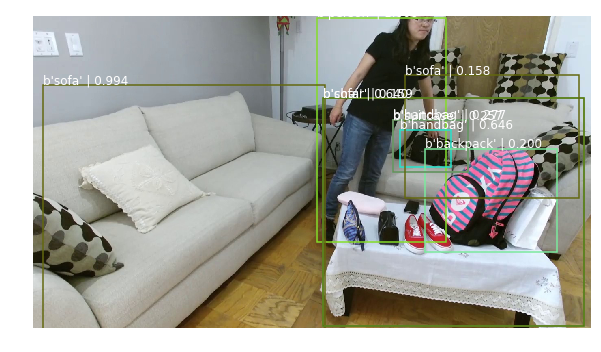

In [60]:
original_images = '/Users/jingyi/study/video_test/test1_image'
detected_images = './'
if not os.path.exists(detected_images):
        os.makedirs(detected_images)
        
colors = dict()
res, name, prob, bounding_box= detect(net, meta, bytes('/Users/jingyi/study/video_test/video_image_set/test1_image/frame5150.jpg',encoding='utf-8'), detected_images, 'frame2001.jpg', colors, thresh=.1, hier_thresh=.1, nms=0.5)
            

In [34]:
print(res)
meta.names[name[5]]

[(0, 0.9994169473648071, (543.650390625, 409.2323303222656, 304.010986328125, 698.1185302734375)), (0, 0.9987694621086121, (946.8233642578125, 343.5180358886719, 160.57667541503906, 499.591064453125)), (28, 0.2852852940559387, (818.1409912109375, 589.5197143554688, 221.91847229003906, 213.0778045654297)), (58, 0.16116425395011902, (304.25408935546875, 508.03033447265625, 124.72818756103516, 155.85317993164062)), (41, 0.14713743329048157, (986.8924560546875, 272.531982421875, 32.06012725830078, 52.38926315307617)), (65, 0.14457252621650696, (986.8924560546875, 272.531982421875, 32.06012725830078, 52.38926315307617)), (65, 0.10578922182321548, (465.5991516113281, 500.0268859863281, 32.9756965637207, 38.38901901245117)), (26, 0.10309723764657974, (442.4706115722656, 621.7940063476562, 207.7499237060547, 221.5265350341797)), (28, 0.10188362002372742, (442.4706115722656, 621.7940063476562, 207.7499237060547, 221.5265350341797))]


b'handbag'

In [35]:
name[5]


26